### not-ETAS: Indonesia September 2018


#### Time
2018-09-28 10:02:43 (UTC)

#### Location
lat = - 0.178
lon = 119.840

#### Depth
10.0 km

#### Mag:
m=7.5

In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
import yodiipy
import yodiipy.pca_tools
#
import contours2kml
import globalETAS as gep
import global_etas_auto as ggep
from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy
#
have_comcat=False
#
# NOTE: these imports should work in both cases, if we sub-module libcomcat or "conda install" it.
try:
    import libcomcat
    import libcomcat.search
    have_comcat = True
except:
    print('comcat not available. consider installing comcat for improved catalog operations;\
          see https://github.com/usgs/libcomcat')

#
# on a fresh linux install... (can we script this?)
# stuff we have to do besides just clone this:
# pip install geopy
# conda install basemap
# pip install geographiclib
# conda install -c ioos rtree


failed while loading urllib and/or urllib. maybe python 3.x?


In [3]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
# for Indonesia 2018, we have 2 m>6 events close together, so let's just run  a couple of these manually
# for the same lat/lon domain.
#
Lr_factor = 10.
#
# mainshock(s):
# (note these are so close together, that we can basically interchange their coordinates for graphical
#    bits).
#
t_ms = dtm.datetime(2018, 9, 28, 10, 2, 43, tzinfo=pytz.timezone('UTC'))
#
#to_dt = t_ms - dtm.timedelta(days=5)
#to_dt = t_ms - dtm.timedelta(days=1)
#to_dt = t_ms - dtm.timedelta(hours=1)
#
# now:
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#
#Location
lat0 = - 0.178
lon0 = 119.840
#
m0 = 7.5
d_lat = 4
d_lon = 4
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#
print('** DEBUG:: lons: {}, lats: {} '.format(lons, lats))

** DEBUG:: lons: [115.84, 123.84], lats: [-4.178, 3.822] 


#### Quick sequence diagnostic
- There have been a lot of earthquakes, so first, let's look at the recent sequence, say over the past year ("past" relative to this sequence, which we may need to maintain, but for now let's assume this whole lot stops  by the end of Sept. 2018)


** rw:  [numpy.datetime64('2018-09-28T10:02:43.480000'), 7.5]


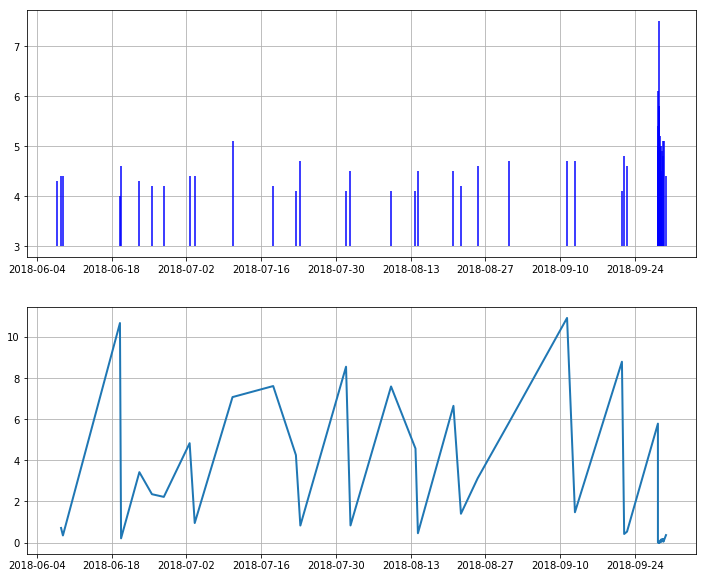

In [4]:
# a quick short catalog and magnitude sequence:
my_cat_prelim = atp.cat_from_comcat(lat=lats, lon=lons, minMag=3.,
                             dates0=[dtm.datetime(2018, 6, 1, 0, 0, tzinfo=pytz.timezone('UTC')), 
                                    dtm.datetime(2018, 9, 30, 0, 0, tzinfo=pytz.timezone('UTC'))])
#
plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212', sharex=ax1)
ax1.grid()
ax2.grid()
#
ax1.vlines(my_cat_prelim['event_date'], my_cat_prelim['mag'], min(my_cat_prelim['mag'])-1., color='b')
ax2.plot(my_cat_prelim['event_date_float'][1:], numpy.diff(my_cat_prelim['event_date_float']),
         ls='-', marker='', lw=2. )
#
for rw in my_cat_prelim[my_cat_prelim['mag']>6.1]:
    print('** rw: ', [rw[s] for s in ('event_date', 'mag')])


In [5]:




#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
cat_len_days = 3650
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 'cat_len':3650,
               'd_lat': .1, 'd_lon':.1, 'mc':2.0,
               'lats': lats, 'p': 1.1, 'b1': 1.0, 'q': 1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76,
               'etas_range_factor': 25.0, 'etas_range_padding':3.}

#nz_cat0 = test_cat = atp.cat_from_geonet(lats=lats, lons=lons, m_c=2.5, date_from=dtm.datetime(2000,1,1,tzinfo=atp.tzutc),
#                              date_to=dtm.datetime.now(atp.tzutc))
#nz_cat = gep.make_ETAS_catalog_mpp(incat=nz_cat0)
#
# TODO: integrate this directly into the globalETAS() class...
#    ... and integrate the new(ish) USGS comcat library. eventually integrate this into anss_tools or 
#    directly into globalETAS module(s). ideally, we want this to operate smoothly, whether or not comcat
#    is installed. so maybe some try...except, or maybe submodule comcat into the project. comcat facilitates
#    really good integration -- they even provide instructions to add a 'conda' channel.
#    anyway, for now, use the globalETAS catalog processing bit; we need a list alonog the lines of:
#    rlist=numpy.rec.array((rlist if len(rlist)>0 else [[]]), dtype=[('event_date', 'M8[us]'), 
#       ('lat','f8'), ('lon','f8'), ('mag','f8'), ('depth','f8'), ('event_date_float', 'f8')])
my_cat = None
#my_cat = atp.cat_from_anss_and_usgs(lons=lons, lats=lats, mc=eq_prams['mc'], cat_len_days=cat_len_days, 
#                            Nmax=None, rec_array=True)
#
########
my_cat = atp.cat_from_comcat(lat=lats, lon=lons, minMag=eq_prams['mc'], dates0=[to_dt-dtm.timedelta(cat_len_days), to_dt])

#my_cat = libcomcat.search.search(starttime=to_dt-dtm.timedelta(cat_len_days),
#                       endtime=to_dt,
#                       minmagnitude=eq_prams['mc'], 
#                       minlatitude=lats[0], maxlatitude=lats[1],
#                       minlongitude=lons[0], maxlongitude=lons[1])
## timezone handling? i think comcat assumes UTC; maybe we just cast using from_num(to_num(dt))
#my_cat = [[ev.time, ev.latitude, ev.longitude, ev.magnitude, ev.depth, mpd.date2num(ev.time)] for ev in my_cat]
#my_cat = numpy.core.records.fromarrays(zip(*my_cat), dtype=[('event_date', 'M8[us]'), 
#       ('lat','f8'), ('lon','f8'), ('mag','f8'), ('depth','f8'), ('event_date_float', 'f8')])
#
###############################
# date_range=['1990-1-1', '{}-{}-{} 23:59:59'.format(to_dt.year, to_dt.month, to_dt.day)],
if not my_cat is None:
    my_cat = gep.make_ETAS_catalog_mpp(incat=my_cat)
#
# TODO: wrap this in Path() objects, or probably one better, integrate patlib.Path() into the .py source codes.
etas_name = 'Indonesia Sept.-Oct. 2018'
f_path = '/home/myoder/Dropbox/Research/etas/Indonesia_2018_09_29/etas_{}'.format(eq_prams['t_now'])
f_root = 'etas_Idonesia_20180929'

print('etas_name: {}'.format(etas_name))
print('f_path: {}'.format(f_path))
print('f_root: {}'.format(f_root))



etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': ['1990-1-1', None], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
etas_name: Indonesia Sept.-Oct. 2018
f_path: /home/myoder/Dropbox/Research/etas/Indonesia_2018_09_29/etas_2018-10-02 17:04:29.802542+00:00
f_root: etas_Idonesia_20180929


In [6]:


# ####
# #Debug comcat:
# my_cat2 = atp.cat_from_comcat(lat=lats, lon=lons, minMag=2.5, dates0=[to_dt-dtm.timedelta(cat_len_days), to_dt])
# #
# plt.figure(figsize=(10,8))
# ax = plt.gca()
# #
# #ax.plot(my_cat['lon'], my_cat['lat'], marker='o', ls='' )
# ax.plot(my_cat['event_date_float'][1:], numpy.diff(my_cat['event_date_float']), '.-')
# ax.plot(my_cat['event_date_float'], my_cat['mag'], '.-')
# #
# ####
# #Debug comcat:
# #
# plt.figure(figsize=(10,8))
# ax = plt.gca()
# #
# #ax.plot(my_cat['lon'], my_cat['lat'], marker='o', ls='' )
# ax.plot(my_cat2['event_date_float'][1:], numpy.diff(my_cat2['event_date_float']), '.-')
# ax.plot(my_cat2['event_date_float'], my_cat2['mag'], '.-')

### Now run (not-)ETAS:
- Note: we might have compiled a composite catalog from ANSS and USGS above. decide if we really want to do that.
  - To use just the ANSS catalog, pass catalog=None, or set my_cat=None before we execute. For domestic events, this is probably the better bet, but only by a little bit. For overseas events, ANSS can take weeks to update, so using the USGS concatenation is a good thing.

In [7]:
#etas = gep.ETAS_mpp(n_cpu=2*mpp.cpu_count(), catalog=nz_cat, **eq_prams)
etas = gep.ETAS_mpp(n_cpu=2*mpp.cpu_count(), catalog=my_cat, **eq_prams)
#
print('*** DEBUG: ')
print('{}, {}, {}, {}'.format(etas.t_now, etas.t_0, etas.t_forecast, mpd.num2date(etas.t_forecast)))

# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-10-04 17:04:29.802542+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1039], None)
make_etas():
etas_mpp worker xyz_range:  [0, 800]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-10-04 17:04:29.802542+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1039], [0, 800])
etas_mpp worker xyz_range:  [800, 1600]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-10-04 17:04:29.802542+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1039], [800, 1600])
etas_mpp worker xyz_range:  [1600, 2400]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now

In [8]:
#
print(to_dt)
print(etas.t_0, mpd.num2date(etas.t_forecast), etas.t_now, t_ms)
#print(etas.catalog[-5:])
#
print('t_now: ', etas.t_now, max(etas.catalog['event_date']))

2018-10-02 17:04:29.802542+00:00
2008-10-04 17:04:29.802542+00:00 2018-10-02 17:04:29.802540+00:00 2018-10-02 17:04:29.802542+00:00 2018-09-28 10:02:43+00:00
t_now:  2018-10-02 17:04:29.802542+00:00 2018-10-02T04:59:26.290000


ms:  (datetime.datetime(2018, 9, 28, 10, 2, 43, 480000), -0.1781, 119.8401, 7.5, 10.0, 736965.4185587963, 97.72372209558107, 3425.9057381088105, 3.4169788522713534e-06, 29.51209226666387, 485.2205219120091, 0.0005387733231909817, 1.0, 1.1, 1.5, array([ 0.14840791,  0.6536539 ]), array([[-0.99852633, -0.05426944],
       [ 0.05426944, -0.99852633]]), 233.0) 119.8401 -0.1781


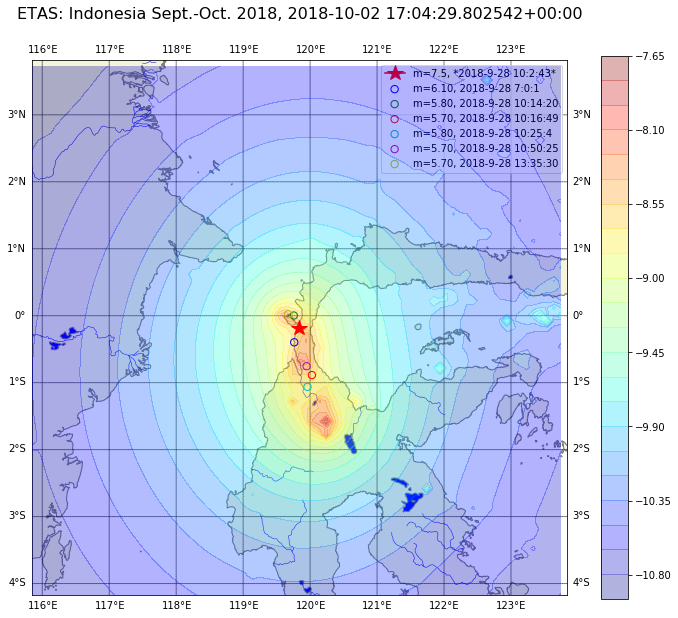

In [9]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

#mainshock = etas.catalog[-1]
mainshock = {'mag':m0, 'lon':lon0, 'lat':lat0, 'event_date':t_ms}
# 2017-11-12 18:18:17 UTC 34.886°N 45.941 W 23.2 km
#
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>=mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])

#print('mm: ', max(etas.catalog['mag']))

#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 5.5
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>t_ms-dtm.timedelta(days=180)]

# plot mainshock:
dt = (mainshock['event_date'].astype(dtm.datetime) if isinstance(mainshock['event_date'], numpy.datetime64)
      else mainshock['event_date'])
#
#dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
etas.cm.plot([mainshock['lon']], [mainshock['lat']], latlon=False, marker='*', color='r', ms=16, zorder=11,
                   label='m={}, *{}*'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(etas_name, etas.t_now), size=16)
#for j,m6 in enumerate(m6s):
for j,m6 in enumerate(sorted(sorted(m6s, key=lambda rw:rw['mag'])[:-1], key=lambda rw:rw['event_date'])):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, latlon=False,
                          c='none', marker='o', zorder=11, label='m={:.2f}, {}'.format(m6['mag'], dt_str))
    #
plt.gca().legend(loc=0)

max_date: 2018-10-02T04:59:26.290000


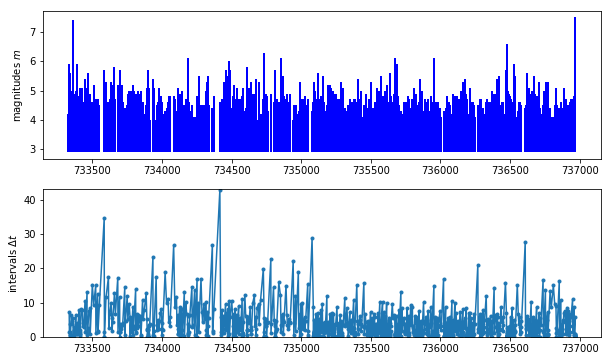

In [10]:
plt.figure(figsize=(10,6))
plt.clf()
ax1 = plt.subplot('211')
ax2 = plt.subplot('212', sharex=ax1)
#ax1.plot(etas.catalog['event_date'], etas.catalog['mag'], marker='.', ls='-', label='mag')
f_dates = [mpd.date2num(x.astype(dtm.datetime)) for x in etas.catalog['event_date']]
ax1.vlines(f_dates, (min(etas.catalog['mag'])-.5)*numpy.ones(len(etas.catalog)), 
           etas.catalog['mag'], lw=2., label='mag', color='b')
ax2.plot(f_dates[1:], numpy.diff(f_dates,1), '.-')

ax2.set_ylabel('intervals $\Delta t$')
ax1.set_ylabel('magnitudes $m$')
ax2.set_ylim(0, 1.25*sorted(numpy.diff(f_dates))[-2])

print('max_date: {}'.format(etas.catalog['event_date'][-1]))

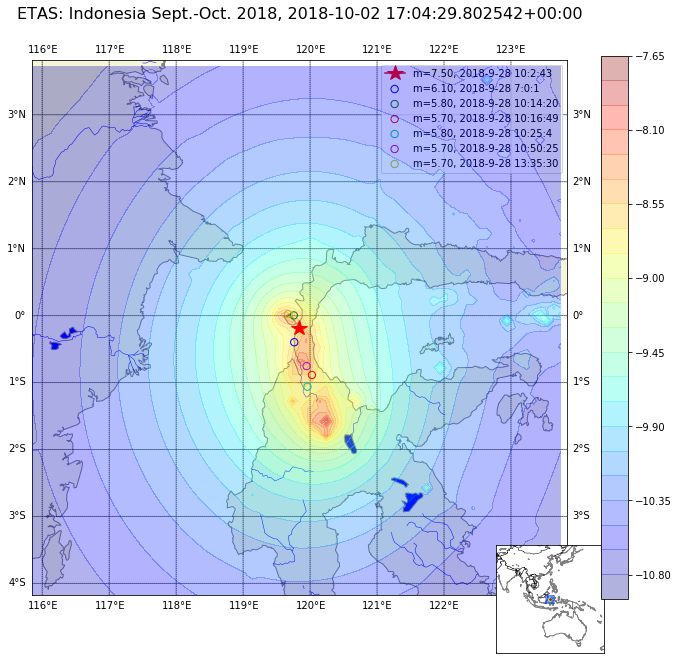

In [11]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
ax_mini = fg.add_axes([.65,.05, .15, .15])
cmap='jet'
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='i', alpha=.3, ax=ax, lats_map=etas.lats,
                          lons_map=etas.lons, map_cmap=cmap)

# etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='l', alpha=.3, ax=ax_mini, lats_map=[-89., 89.],
#                           lons_map=[-180., 180.], lat_interval=10., lon_interval=10.)

ll_lon_mini = max(-180, lon0-50.)
ll_lat_mini = max(-89, lat0-50)
ur_lon_mini = min(180., lon0+50.)
ur_lat_mini = min(89, lat0+50)
mp_mini = Basemap(llcrnrlon=ll_lon_mini, llcrnrlat=ll_lat_mini,
                                urcrnrlon=ur_lon_mini, urcrnrlat=ur_lat_mini,
                  resolution='l', projection=etas.cm.projection, lon_0=0., lat_0=0., ax=ax_mini)
mp_mini.drawcoastlines(color='gray', zorder=1)
mp_mini.drawcountries(color='black', zorder=1)

mp_mini.plot([x], [y], latlon=False, marker='*', color='r', ms=2, zorder=24)
#
X,Y = etas.cm(numpy.array(etas.lonses), numpy.array(etas.latses))
Z = numpy.log10(etas.lattice_sites)
#ax_mini.set_ylim(ll_lat_mini, ur_lat_mini)
#ax_mini.set_xlim(ll_lon_mini, ur_lon_mini)
#
etas_contours = ax_mini.contourf(X,Y, Z, 15, zorder=8, alpha=.3, cmap=cmap)
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 5.5 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=120)]
#
# plot mainshock:
dt = (mainshock['event_date'].astype(dtm.datetime) if isinstance(mainshock['event_date'], numpy.datetime64)
      else mainshock['event_date'])
dt_ms_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
                   label='m={:.2f}, {}'.format(mainshock['mag'], dt_ms_str))
ax.set_title('ETAS: {}, {}\n\n'.format(etas_name, etas.t_now), size=16)
#for j,m6 in enumerate(m6s):
for j,m6 in enumerate(sorted(sorted(m6s, key=lambda rw:rw['mag'])[:-1], key=lambda rw:rw['event_date'])):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={:.2f}, {}'.format(m6['mag'], dt_str))
    #
ax.legend(loc=0)

In [12]:
#print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
#len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
#     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])

print(dt, type(dt), dt.year)

2018-09-28 13:35:30.360000 <class 'datetime.datetime'> 2018


In [13]:
for rw in m6s:
    print(rw)

(datetime.datetime(2018, 9, 28, 7, 0, 1, 950000), -0.3976, 119.7631, 6.1, 18.08, 736965.2916892361, 19.498445997580443, 108.33665181464141, 0.0004826610918015261, 5.88843655355589, 11.287709588108326, 0.01971239610020865, 1.0, 1.1, 1.5, array([ 0.00513395,  0.01978569]), array([[-0.99978035, -0.0209583 ],
       [ 0.0209583 , -0.99978035]]), 24.0)
(datetime.datetime(2018, 9, 28, 10, 2, 43, 480000), -0.1781, 119.8401, 7.5, 10.0, 736965.4185587963, 97.72372209558107, 3425.9057381088105, 3.4169788522713534e-06, 29.51209226666387, 485.2205219120091, 0.0005387733231909817, 1.0, 1.1, 1.5, array([ 0.14840791,  0.6536539 ]), array([[-0.99852633, -0.05426944],
       [ 0.05426944, -0.99852633]]), 233.0)
(datetime.datetime(2018, 9, 28, 10, 14, 20, 450000), 0.0023, 119.7561, 5.8, 10.0, 736965.4266255787, 13.803842646028846, 51.68289565050985, 0.0013943011214220353, 4.168693834703355, 5.0420346659731, 0.04263236419296551, 1.0, 1.1, 1.5, array([ 0.00964012,  0.01129407]), array([[-0.98128928, -0.19

In [14]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))), 
                kml_contours_bottom=.25, kml_contours_top=1.0)

etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
#
# this appears to be unreliable, maybe some sort of version difference in basemap? looks like we need a smarter
#  way to save and reinstantiate these objects.
try:
    with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
        pickle.dump(etas, fpkl)
except:
    print('unable to pickle not-ETAS object :( ')

kml bottom, top:  5 22


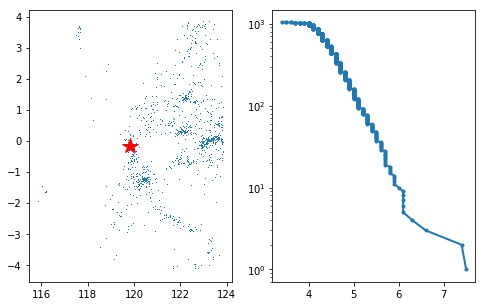

In [15]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [16]:
#print(etas.mc, etas.mc_etas)

### ETAS cross-sections:
- What is the best way to produce an ETAS cross section?
#### PCA and coordinate rotation method(s):
- Start with a more or less contemporary method; compute (global) PCA; rotate along the major axis; cross section is the median "x'" row.
  - Variations: mean-subtract via (un-) weighted or custom location (to specify the center of rotation)
  - ???
##### Comment on this method:
- Straight forward(ish) in principle, and fairly conventional in the Physics community, but potentially compute intensive, and clumsy to customize or do anything but straight lines.
- Also, this breaks the grid-symmetry of the lattice (it rotates the whole lattice), so plotting, etc. of the rotated frame would require reconstruction onto a new lattice.
- Even if we don't want to do gridded plots, it moves points off of the original lattice, for whatever that's worth.

### TODO items:

####
Add bounds selection (done?):
- We've started with PCA over the full map domain, assuming the 'mainshock' dominates/characterizes the space.
- Obviously, this will not always be the case, so add options to select a lat/lon subdomain.
- Then, we move on to the generalized NN-interpoladed cross section

#### TODO:add cross-section image; saved with main ETAS image.

#### NN to any user defined path:
- Designate a path -- it can be a straight line.
- Use an *sklearn* NN finding algorithm to find the closest $n$ points in the ETAS map to each point in the path (we will need to define our path to have sufficient resolution)
- Compute the z-value for each point on the path from a mean (presumably weighted by distance) between each point on the path and its NN values.
- Note: we could generalize this to use the entie map for each point... which might be interesting as well.
- Note: we'll need some sort of Omori like weighting, to handle singularities, but this can be more or less arbitrarily chosen.... and it's just the weighting, so it should not have huge effect in most cases.
- **Note possible application:** We might use something like this to stitch together smaller earthquakes (ETAS halos) to estimate rupture-hazard zones for larger events (aka, stitch togetehr hot-spots that are more or less in a line, or consistent with a geophysical profile (regional faults) of some sort).


In [17]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#XYw = numpy.array([[x*z, y*z] for x,y,z in etas.ETAS_array])
#### DEPRICATION WARNING: this class definition moved to yodiipy.pca_tools.py module.

pca_cross   = yodiipy.pca_tools.PCA_cross_section(XYW = numpy.array([etas.ETAS_array['x'], etas.ETAS_array['y'], 
                                        numpy.log(etas.ETAS_array['z'])]).T,
                             x_min=None, x_max=None, y_min=None, y_max=None, n_NN=4, )
pca_cross_2 = yodiipy.pca_tools.PCA_cross_section(XYW = numpy.array([etas.ETAS_array['x'], etas.ETAS_array['y'],
                                        numpy.log(etas.ETAS_array['z'])]).T,
                             x_min=None, x_max=None, y_min=None, y_max=None, n_NN=4, )


#### Cross-section examples
- First, let's have a look at the pca_cross object's eigen-vector basis
- Illustrate a couple of ways to access those vectors as basis vectors, a transformation matrix, etc.

-0.3760146615354754
0.999999991334636
eig_vecs.T:  [(0.0, 0.99721008258109933), (0, 0.074646173368746641)]
dot_vecs:  0.0
dot_e:  0.0
dot_e:  0.0
e1, e2:  [ 0.99721008  0.07464617] [-0.07464617  0.99721008]
e1, e2:  [ 0.99721008  0.07464617] [-0.07464617  0.99721008]


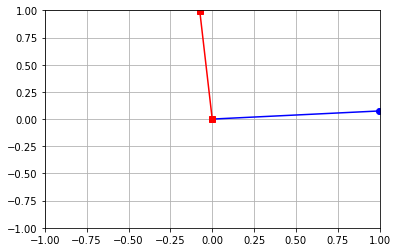

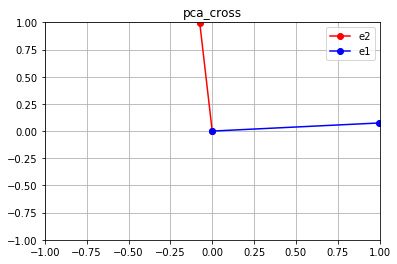

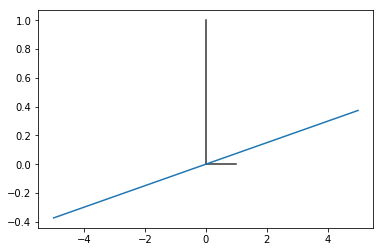

In [18]:
print(0.35195595/(-0.93601656))
print(0.35195595**2. + (-0.93601656)**2.)

fg = plt.figure()
ax=plt.gca()
#
ax.plot(*zip([0.,0.], pca_cross.eig_vecs.T[0]), color='b', ls='-', marker='o')
ax.plot(*zip([0.,0.], pca_cross.eig_vecs.T[1]), color='r', ls='-', marker='s')
#ax.plot(range(2), [0., 0.], color='k', alpha=.5, ls='-')
ax.grid()
ax.set_ylim(-1., 1.)
ax.set_xlim(-1., 1.)


fg = plt.figure()
ax=plt.gca()
#
# ax.plot([0., pca_cross.eig_vecs[0][0]], [0., pca_cross.eig_vecs[1][0]], color='b', ls='-', marker='o')
# ax.plot([0., pca_cross.eig_vecs[0][1]], [0., pca_cross.eig_vecs[1][1]], color='b', ls='-', marker='o')


#ax.plot([0., pca_cross.e1[0]], [0., pca_cross.e1[1]], color='r', ls='-', marker='o')
ax.plot(*zip([0., 0.], pca_cross.e2), color='r', ls='-', marker='o', label='e2')
ax.plot(*zip([0., 0.], pca_cross.e1), color='b', ls='-', marker='o', label='e1')
ax.set_title('eig_vals: {}'.format(pca_cross.eig_vals))
ax.grid()
ax.set_ylim(-1., 1.)
ax.set_xlim(-1., 1.)
ax.set_title('pca_cross')
ax.legend(loc=0)
#
print('eig_vecs.T: ', list(zip([0.,0], pca_cross.eig_vecs.T[0])))
print('dot_vecs: ', numpy.dot(pca_cross.eig_vecs.T[0], pca_cross.eig_vecs.T[1]))
print('dot_e: ', numpy.dot(pca_cross.e1, pca_cross.e2))
print('dot_e: ', numpy.dot(pca_cross_2.e1, pca_cross_2.e2))

print('e1, e2: ', pca_cross.e1, pca_cross.e2)
print('e1, e2: ', pca_cross_2.e1, pca_cross_2.e2)

#
plt.figure()
plt.clf()
ax = plt.gca()
XY = [pca_cross_2.e1*x for x in numpy.linspace(-5., 5., 100)]
ax.plot([0., 0.], [0., 1.], color='k', alpha=.8)
ax.plot([0., 1.], [0., 0.], color='k', alpha=.8)

ax.plot(*zip(*XY), ls='-', marker='')


### PCA Transform 
- Get a cross-section via PCA transformation (rotation to principal axes basis)
- Note: We plot the original image using impshow(), but the rotated image is 1) no longer square, and 2) no longer on a regular lattice, so we have to do some refactoring, namely to rotate the image into a square frame and interpolate it onto a regular (pixelated) lattice.
- We show what happens when this is not done
- We show a quick-n-easy scatter() plot method to plot the rotated image without doing this. This method is scale dependent (aka, it will be sparse if the image is big and blurry/blotchy if the image is small) because the 'scatter' pixels are of fixed size. There are smarter ways to do this, but right now we're just using it to eye-ball the rotation.
- We can then grab the median row from the rotated image to get a cross-section. This is less trivial than it sounds, since in order to really do this, we need to snap the pixels to a lattice or come up with some other criteria for continuity.
- In the end, we revise this basic approach by externally defining a sequence along the principal axis, of some arbitrary resolution, and computing the mean() (or some other aggregate) z-value based from the N nearest neighbors.


dx, dy:  0.1 0.1


Text(0.5,1,'XY primed (wrong)')

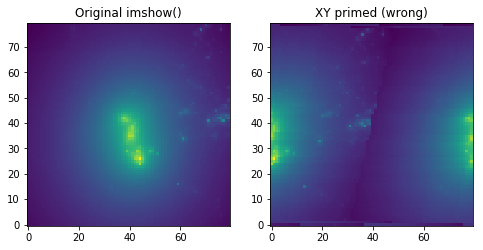

In [19]:
# get zero-centered, etc. arrays for PCA:
#
XY_prime = etas.ETAS_array.copy()
XY_prime['x'] -= numpy.mean(XY_prime['x'])
XY_prime['y'] -= numpy.mean(XY_prime['y'])
XY_prime['z'] = numpy.log(XY_prime['z'])
#
X  = sorted(set(XY_prime['x']))
dx = numpy.mean(numpy.diff(X))
Y  = sorted(set(XY_prime['y']))
dy = numpy.mean(numpy.diff(Y))
#
#XY_prime['x'], XY_prime['y'] = numpy.dot(eig_vecs, numpy.array([XY_prime['x'], XY_prime['y']]))
#XY_prime = sorted(list(XY_prime), key=lambda rw: (rw[0], rw[1]))
#
#print('lens: ', len(XY_prime), len(XYw))
plt.figure(figsize=(8,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax1.imshow(numpy.reshape(XY_prime['z'], (len(Y), len(X))), origin='lower')
ax1.set_title('Original imshow()')
#
#XY_prime['x'], XY_prime['y'] = numpy.dot(pca_cross.eig_vecs, numpy.array([XY_prime['x'], XY_prime['y']]))
XY_prime['x'], XY_prime['y'] = numpy.dot(pca_cross.eig_vecs_inv, numpy.array([XY_prime['x'], XY_prime['y']]))
#
# Snap to lattice:
# now, we need to 'snap' (x,y) to a regular lattice. a few options for this, like x' = x - x%dx
#   but we nominally want to snap to the closest point... we also need to fill in the lattice, so this is
#   not super simple if we want to do contours, imshow(), etc. but to just get data... we can do this.
# NOTE: on way to do this woould be to interpolate onto the new XY axes usingg scipy.interpolate.interp2d().
#
XY_prime['x'] = dx*numpy.round(XY_prime['x']/dx)
XY_prime['y'] = dy*numpy.round(XY_prime['y']/dy)
#
print('dx, dy: ', dx, dy)
#XY_prime = sorted([[x,y,z] for x,y,z in XY_prime], key=lambda rw: (rw[0], rw[1]))
#
XY_prime.sort(order = ('y', 'x'))
#
# ... and note this simple approach will not work, since the data are no longer square, or at least
#  not square and aligned on the orignial XY axes.
ax2.imshow(numpy.reshape([z for x,y,z in XY_prime], (len(X), len(Y))), origin='lower')
#ax2.contourf(XY_prime['x'], XY_prime['y'], XY_prime['z'], N=15)
ax2.set_title('XY primed (wrong)')
#

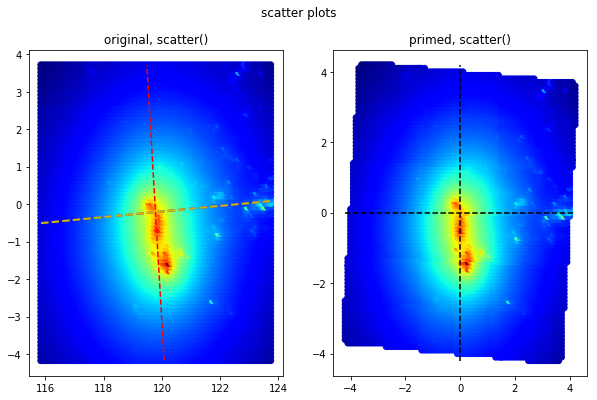

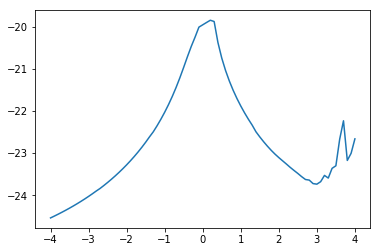

In [20]:
# done correctly(ish):
# TODO: these figures integrated with cross-sections below. get rid of all this...
#
plt.figure(figsize=(10,6))
plt.clf()
plt.suptitle('scatter plots')
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
ax1.scatter(x=etas.ETAS_array['x'], y=etas.ETAS_array['y'], c=numpy.log(etas.ETAS_array['z']),
            cmap='jet')

ax2.scatter(x=XY_prime['x'], y=XY_prime['y'], c=XY_prime['z'], cmap='jet')
ax2.plot([min(XY_prime['x']), max(XY_prime['x'])], [0.,0.], ls='--', marker='', zorder=11, color='k')
ax2.plot([0., 0.], [min(XY_prime['y']), max(XY_prime['y'])], ls='--', marker='', zorder=11, color='k')
#
ax1.set_title('original, scatter()')
ax2.set_title('primed, scatter()')
#
x0 = numpy.mean(etas.ETAS_array['x'])
y0 = numpy.mean(etas.ETAS_array['y'])
#
b_major = pca_cross_2.eig_vecs.T[1][1]/pca_cross_2.eig_vecs.T[1][0]
#
# TODO: reconsile this transformation; i think this local calculation is wrong:
#
#ax1.plot(*zip(*pca_cross), color='r', ls='--', lw=2., zorder=12)
#
# ax1.plot(*zip(*pca_cross_2.get_cross_section_xy_lin_func(b=pca_cross_2.b_minor, 
#                 y_min=min(pca_cross_2.Y_pca), y_max=max(pca_cross_2.Y_pca))),
#          ls='--', lw=2., color='b', zorder=12)
#
ax1.plot(*zip(*pca_cross_2), color='m', ls='--', lw=2., zorder=12)
ax1.plot(*zip(*pca_cross_2.get_cross_section_xy(minor=False, 
                y_min=min(pca_cross_2.Y_pca), y_max=max(pca_cross_2.Y_pca))),
         ls='--', lw=2., color='y', zorder=12)
ax1.plot(*pca_cross_2.minor_axis.T, color='r', ls='--')

#
#########################################
#########################################

#
# now, get the median row, along the x' axis. note: we want to be careful to get an actual y-value, not
#  an intermediate, and the data are no longer properly gridded... but they are snapped to a grid.
y_med = sorted(XY_prime['y'])[int(.5*len(XY_prime))]
x_section = [[x,z] for x,y,z in XY_prime if y==y_med]
plt.figure()
ax=plt.gca()
ax.plot(*zip(*x_section), ls='-', marker='')
# plt.figure()
# ax=plt.gca()
# ax.plot([z for x,y,z in XY_prime if y==y_med], ls='-', marker='')
#
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

#etas.make_etas_contour_map()

v1, v2:  [7.8999999999995509, 0.59135460011266627] [-0.58970476961309259, 7.8779596523906577]
***  3.01980662698e-14


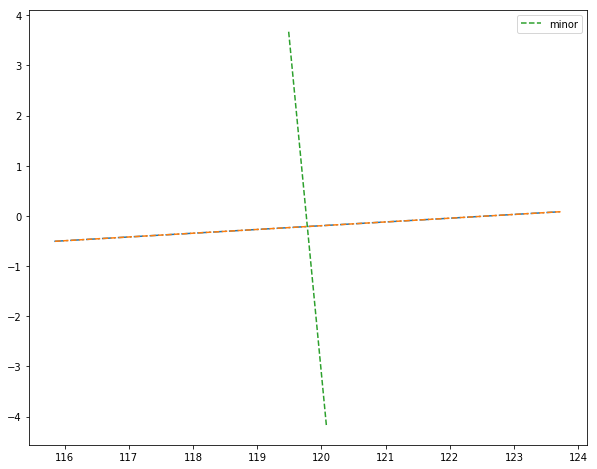

In [21]:
pca_cross3   = yodiipy.pca_tools.PCA_cross_section(XYW = numpy.array([etas.ETAS_array['x'], etas.ETAS_array['y'], 
                                        numpy.log(etas.ETAS_array['z'])]).T,
                             x_min=None, x_max=None, y_min=None, y_max=None, n_NN=4, )


plt.figure(figsize=(10,8))
ax=plt.gca()
xy_cross  = pca_cross3.get_cross_section_xy_lin_func()
xy_cross2 = pca_cross3.get_cross_section_xy()
xy_cross3 = pca_cross3.get_cross_section_xy(minor=True)

ax.plot(*xy_cross.T, '-.')
ax.plot(*xy_cross2.T, '--')
ax.plot(*xy_cross3.T, '--', label='minor')

ax.legend(loc=0)

#
v1 = [xy_cross[-1][0] - xy_cross[0][0], xy_cross[-1][1] - xy_cross[0][1]]
v2 = [xy_cross3[-1][0] - xy_cross3[0][0], xy_cross3[-1][1] - xy_cross3[0][1]]

print('v1, v2: ', v1, v2)
print('*** ', numpy.dot(v1, v2))

### NN based cross section:
- A better (??) approach to finding teh cross-section is to define the geospatial cross-section trace vector and then aggregate the $N_{nn}$ nearest-neighbor values to that point. Note that the cross-section trace need not lie on the image lattice.
- Note that this approach facilitates some interesting interpretations of this metric. For exmple, we might evaluate the cross-section trace based on the $w \propto 1/r^q$ weighted average of all points in the lattice.


lens:  6400 6400 6400 6400
*** lens2:  6400


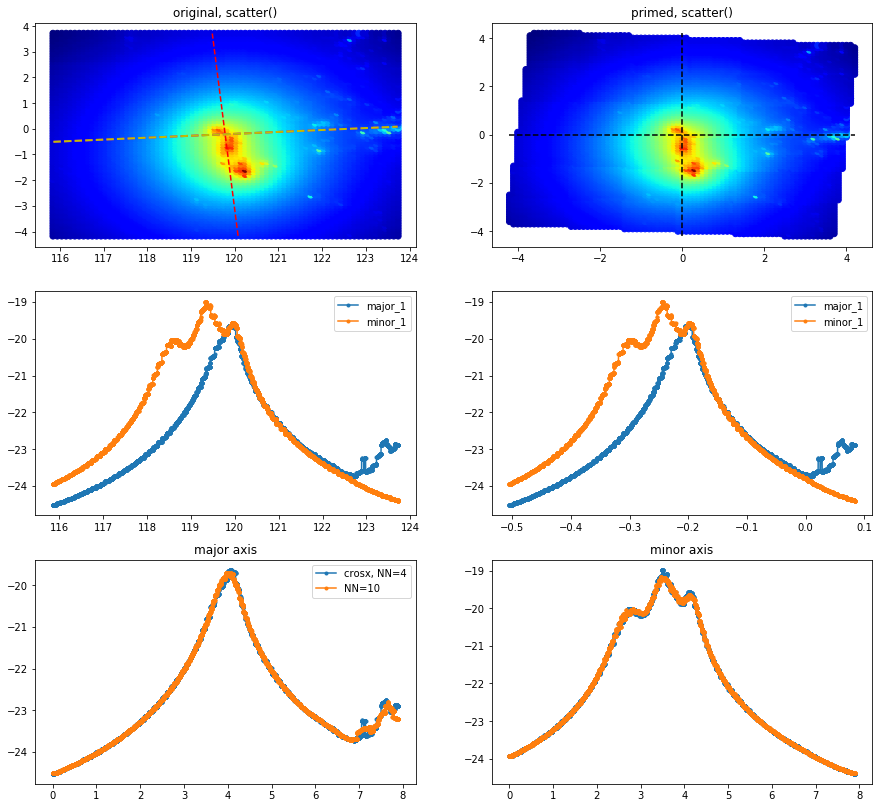

In [22]:
#
# this appears to be happening backwards; "True" seems to return the major axis...
my_vec = pca_cross_2.get_cross_section_xy(minor=False)
#my_vec = pca_cross_2.get_cross_section_xy(minor=True) 
#b=pca_cross_2.b_minor, 
#                y_min=min(pca_cross_2.Y_pca), y_max=max(pca_cross_2.Y_pca))
zs = pca_cross_2.get_cross_section_zs(XY_xc=pca_cross_2.get_cross_section_xy(minor=False), n_NN=4)

print('lens: ', len(my_vec), len(zs), len(pca_cross_2), len(pca_cross))
xy_mean = numpy.average(pca_cross.XYW.T[0:2].T, weights=pca_cross.XYW.T[2], axis=0)
xy_cross = xy_mean + numpy.array([pca_cross_2.e2*x for x in numpy.linspace(-3.,3.,1000)])

fg=plt.figure(figsize=(15,14))
ax1 = plt.subplot('321')
ax2 = plt.subplot('322')
ax3 = plt.subplot('323')
ax4 = plt.subplot('324')
#
ax5 = plt.subplot('325')
ax6 = plt.subplot('326')
#
#####################
ax1.scatter(x=etas.ETAS_array['x'], y=etas.ETAS_array['y'], c=numpy.log(etas.ETAS_array['z']),
            cmap='jet')

ax2.scatter(x=XY_prime['x'], y=XY_prime['y'], c=XY_prime['z'], cmap='jet')
ax2.plot([min(XY_prime['x']), max(XY_prime['x'])], [0.,0.], ls='--', marker='', zorder=11, color='k')
ax2.plot([0., 0.], [min(XY_prime['y']), max(XY_prime['y'])], ls='--', marker='', zorder=11, color='k')
#
ax1.set_title('original, scatter()')
ax2.set_title('primed, scatter()')
#
x0 = numpy.mean(etas.ETAS_array['x'])
y0 = numpy.mean(etas.ETAS_array['y'])
#
b_major = pca_cross_2.eig_vecs.T[1][1]/pca_cross_2.eig_vecs.T[1][0]
#
# TODO: reconsile this transformation; i think this local calculation is wrong:
#
#ax1.plot(*zip(*pca_cross), color='r', ls='--', lw=2., zorder=12)
#
# ax1.plot(*zip(*pca_cross_2.get_cross_section_xy_lin_func(b=pca_cross_2.b_minor, 
#                 y_min=min(pca_cross_2.Y_pca), y_max=max(pca_cross_2.Y_pca))),
#          ls='--', lw=2., color='b', zorder=12)
#
ax1.plot(*zip(*pca_cross_2), color='m', ls='--', lw=2., zorder=12)
ax1.plot(*zip(*pca_cross_2.get_cross_section_xy(minor=False, 
                y_min=min(pca_cross_2.Y_pca), y_max=max(pca_cross_2.Y_pca))),
         ls='--', lw=2., color='y', zorder=12)
ax1.plot(*pca_cross_2.minor_axis.T, color='r', ls='--')

#####################
#
ax3.plot( [x for x,y in pca_cross_2],
          pca_cross_2.get_cross_section_zs(pca_cross_2.get_cross_section_xy(minor=False)), label='major_1',
          ls='-', marker='.' )


ax3.plot( [x for x,y in pca_cross_2],
          pca_cross_2.get_cross_section_zs(pca_cross_2.get_cross_section_xy(minor=True)), label='minor_1',
          ls='-', marker='.' )
###
ax4.plot( [y for x,y in pca_cross_2],
          pca_cross_2.get_cross_section_zs(pca_cross_2.get_cross_section_xy(minor=False)), label='major_1',
          ls='-', marker='.' )


ax4.plot( [y for x,y in pca_cross_2],
          pca_cross_2.get_cross_section_zs(pca_cross_2.get_cross_section_xy(minor=True)), label='minor_1',
          ls='-', marker='.' )


###
print('*** lens2: ', len(pca_cross_2.dist_axis()))
ax5.plot(pca_cross_2.dist_axis(), pca_cross_2.get_cross_section_zs(), label='crosx, NN=4', ls='-', marker='.')
ax5.plot(pca_cross_2.dist_axis(), pca_cross_2.get_cross_section_zs(n_NN=10), label='NN=10', ls='-', marker='.')
#
ax6.plot(pca_cross_2.dist_axis(), pca_cross_2.get_cross_section_zs(XY_xc=pca_cross_2.minor_axis),
         label='crosx, NN=4', ls='-', marker='.')
ax6.plot(pca_cross_2.dist_axis(), pca_cross_2.get_cross_section_zs(XY_xc=pca_cross_2.minor_axis, n_NN=10), 
         label='NN=10', ls='-', marker='.')

ax3.legend(loc=0)
ax4.legend(loc=0)
ax5.legend(loc=0)
#
ax5.set_title('major axis')
ax6.set_title('minor axis')
#
# TODO: plot XY from XY#_pca
fg.savefig(os.path.join(f_path, '{}_{}_xsection.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))

In [23]:
print('*** ', len(pca_cross_2))

***  6400


In [24]:
#mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=2.5, 
                            dates0=[dtm.datetime(2005,1,1), None], Nmax=None, fout=None,
                            )


data handle fetched...
 no file.
[ (datetime.datetime(2012, 11, 26, 0, 44, 52, 350000), -2.764, 121.342, 4.3, 35.0, 734833.0311614583)
 (datetime.datetime(2012, 12, 1, 19, 6, 46, 160000), -0.638, 123.593, 4.6, 45.4, 734838.7963675926)
 (datetime.datetime(2012, 12, 17, 9, 16, 28, 310000), -0.708, 123.837, 6.1, 18.5, 734854.3864387731)
 (datetime.datetime(2012, 12, 22, 2, 4, 22, 800000), -2.69, 119.948, 4.9, 42.6, 734859.086375)
 (datetime.datetime(2012, 12, 28, 17, 32, 17, 240000), -0.245, 122.94, 5.5, 104.4, 734865.7307550926)]
2012-12-28T17:32:17.240000


<Figure size 432x288 with 0 Axes>

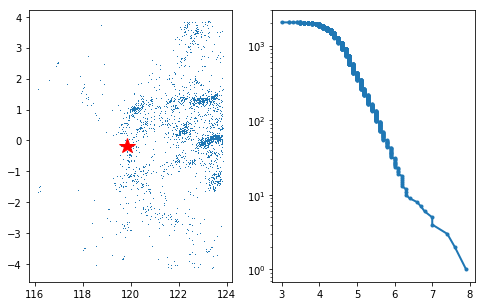

In [25]:
# TODO: take a look at the ComCat library, which should combine multiple catalogs and may provide
#  tensor solution information, like strike, etc.
#
test_cat = atp.catfromANSS(lat=lats, lon=lons, minMag=1.5,
                           dates0=[dtm.datetime(1990,1,1, tzinfo=pytz.utc), dtm.datetime.now(pytz.utc)])


plt.figure()
plt.clf()
#plt.plot(test_cat['lon'], test_cat['lat'], '.')
print(test_cat[-5:])
print(max(test_cat['event_date']))

plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(test_cat['lon'], test_cat['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(test_cat['mag']))], numpy.arange(1,len(test_cat)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

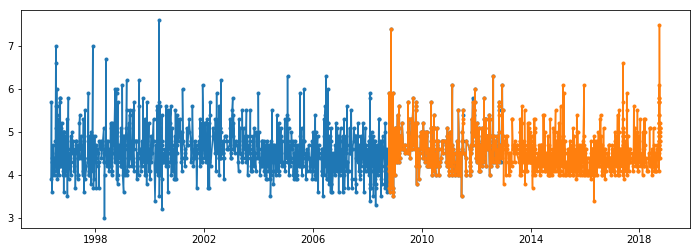

In [26]:
plt.figure(figsize=(12,4))
plt.clf()
ax=plt.gca()
n=1500
ax.plot(test_cat['event_date'][-n:], test_cat['mag'][-n:], '.-')
ax.plot(etas.catalog['event_date'][-n:], etas.catalog['mag'][-n:], '.-')

In [27]:
test_cat[-10:]

rec.array([ (datetime.datetime(2012, 11, 6, 6, 27, 52, 300000), 1.536, 122.409, 4.4, 29.7, 734813.2693553241),
 (datetime.datetime(2012, 11, 7, 8, 18, 20, 840000), 0.283, 122.196, 4.4, 183.3, 734814.346074537),
 (datetime.datetime(2012, 11, 11, 22, 44, 12, 250000), 0.294, 122.292, 4.5, 162.0, 734818.9473640047),
 (datetime.datetime(2012, 11, 13, 12, 42, 50, 760000), 0.246, 122.292, 4.4, 156.2, 734820.5297541667),
 (datetime.datetime(2012, 11, 15, 22, 10, 25, 150000), -0.026, 123.43, 4.7, 158.5, 734822.923902199),
 (datetime.datetime(2012, 11, 26, 0, 44, 52, 350000), -2.764, 121.342, 4.3, 35.0, 734833.0311614583),
 (datetime.datetime(2012, 12, 1, 19, 6, 46, 160000), -0.638, 123.593, 4.6, 45.4, 734838.7963675926),
 (datetime.datetime(2012, 12, 17, 9, 16, 28, 310000), -0.708, 123.837, 6.1, 18.5, 734854.3864387731),
 (datetime.datetime(2012, 12, 22, 2, 4, 22, 800000), -2.69, 119.948, 4.9, 42.6, 734859.086375),
 (datetime.datetime(2012, 12, 28, 17, 32, 17, 240000), -0.245, 122.94, 5.5, 104.

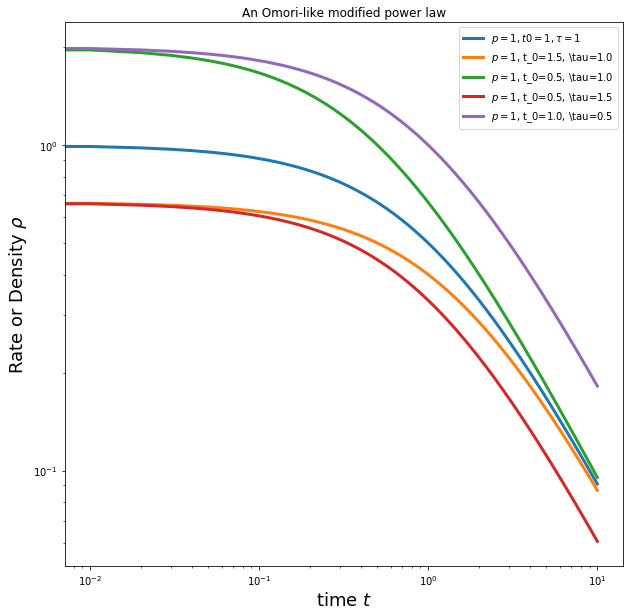

In [28]:
plt.figure(figsize=(10,10))
ax = plt.gca()

def f_omori(t, tau=1., t0=1., p=1.):
    return 1./(tau*(t0 + t)**p)

X = numpy.linspace(0., 10., 1000)

ax.plot(X, f_omori(X, p=1.00), ls='-', marker='', lw=3., label='$p=1, t0=1, \\tau=1$')
#ax.plot(X, f_omori(X, p=1.5), ls='-', marker='', lw=3., label='$p=1.5$')

ax.plot(X, f_omori(X, t0=1.5, p=1.00), ls='-', marker='', lw=3., label='$p=1$, t_0=1.5, \\tau=1.0')
ax.plot(X, f_omori(X, t0=.5, p=1.00), ls='-', marker='', lw=3., label='$p=1$, t_0=0.5, \\tau=1.0')

ax.plot(X, f_omori(X, p=1.00, tau=1.5), ls='-', marker='', lw=3., label='$p=1$, t_0=0.5, \\tau=1.5')
ax.plot(X, f_omori(X, p=1.00, tau=.5), ls='-', marker='', lw=3., label='$p=1$, t_0=1.0, \\tau=0.5')

#
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('time $t$', size=18)
ax.set_ylabel('Rate or Density $\\rho$', size=18)
ax.set_title('An Omori-like modified power law')
ax.legend(loc=0)



(numpy.record, [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8'), ('L_r', '<f8'), ('r_0', '<f8'), ('chi', '<f8'), ('dt_r', '<f8'), ('t_0', '<f8'), ('tau', '<f8'), ('dmstar', '<f8'), ('p', '<f8'), ('q', '<f8'), ('e_vals', '>f8', (2,)), ('e_vecs', '>f8', (2, 2)), ('N_eig_cat', '>f8')])
['2008-10-11T13:42:46.800000' '2008-10-18T18:06:39.610000'
 '2008-10-20T04:54:19.240000' '2008-10-21T09:39:54.490000'
 '2008-10-25T00:16:57.660000']


numpy.datetime64

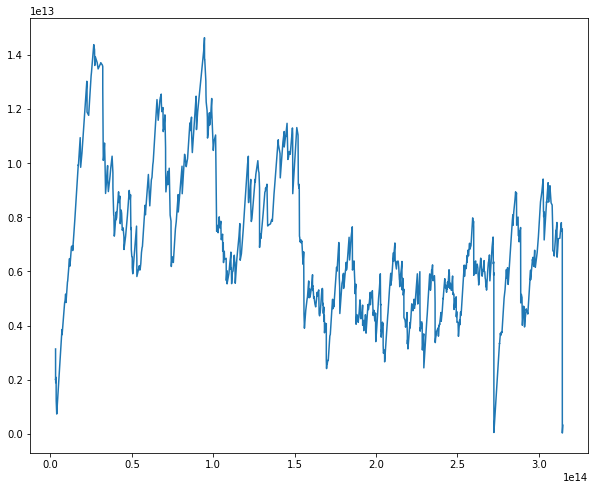

In [29]:
plt.figure(figsize=(10,8))
ax = plt.gca()
X = numpy.array([x.astype(float) for x in etas.catalog['event_date']])
X -= min(X)
n = 20
Y = numpy.array([x2 - x1 for x1,x2 in zip(X[0:-n], X[n:]) ])

ax.plot(X[n:], Y)
#ax.set_yscale('log')

print(etas.catalog.dtype)
print(etas.catalog['event_date'][0:5])
type(etas.catalog['event_date'][0])

In [30]:
a_vals = numpy.array([-2.3, -2.64, -3.18, -1.79])
p_vals = numpy.array([.83, .96, 1.15, .94])
c_vals = numpy.array([.0033, .012, .050, .026])

rts = (10**a_vals)/(c_vals**p_vals)
print('*** ', rts)


***  [ 0.57495444  0.15995065  0.02071021  0.50110075]
